In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
print("슝=3")

슝=3


In [2]:
import pickle 

# loading
with open('data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [3]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8333


In [1]:
from model import encoder, decoder, create_padding_mask, create_look_ahead_mask, transformer

In [6]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3187456     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [7]:
MAX_LENGTH = 40
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [8]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

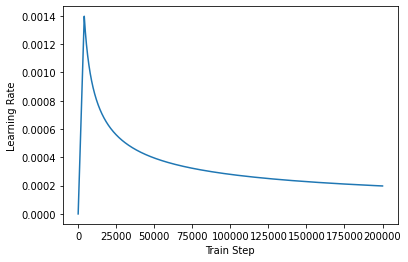

In [9]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [10]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [11]:
data = np.load('data/dataset.npz')
questions = data['questions']
answers = data['answers']
print(len(questions))
print(len(answers))

44095
44095


In [12]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


In [13]:
import os
import tensorflow as tf

# 체크포인트가 저장될 디렉토리
checkpoint_dir = './training_checkpoints'
# 체크포인트 파일 이름
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [14]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback], verbose=1)

Epoch 1/20
689/689 [==============================] - 89s 119ms/step - loss: 2.5021 - accuracy: 0.0245
Epoch 2/20
689/689 [==============================] - 82s 119ms/step - loss: 1.5493 - accuracy: 0.0769
Epoch 3/20
689/689 [==============================] - 82s 119ms/step - loss: 1.4144 - accuracy: 0.0854
Epoch 4/20
689/689 [==============================] - 82s 119ms/step - loss: 1.3377 - accuracy: 0.0907
Epoch 5/20
689/689 [==============================] - 82s 119ms/step - loss: 1.2915 - accuracy: 0.0951
Epoch 6/20
689/689 [==============================] - 82s 119ms/step - loss: 1.2322 - accuracy: 0.0994
Epoch 7/20
689/689 [==============================] - 82s 119ms/step - loss: 1.1737 - accuracy: 0.1029
Epoch 8/20
689/689 [==============================] - 82s 119ms/step - loss: 1.1147 - accuracy: 0.1093
Epoch 9/20
689/689 [==============================] - 82s 119ms/step - loss: 1.0539 - accuracy: 0.1150
Epoch 10/20
689/689 [==============================] - 82s 119ms/step - l